# sPOD-NN for 1D wildland fire data

In [1]:
import sys
sys.path.append('../sPOD/lib/')
sys.path.append('../DL-ROM/LIB/')

In [2]:
from wildfire1D_sup import wildfire1D_sup
import numpy as np

## Data generation / sPOD of the data

In [3]:
variable = 0  # 0 for temperature and 1 for supply mass fraction
test_val = 558.49

if variable == 0:
    name = "T"
else:
    name = "S"

In [4]:
import os

q = np.load(os.path.abspath(".") + '/wildfire_data/1D/' + 'SnapShotMatrix' + str(test_val) + '.npy')
shifts_test= np.load(os.path.abspath(".") + '/wildfire_data/1D/' + 'Shifts' + str(test_val) + '.npy')

df = wildfire1D_sup(q, shifts_test, param_test_val=test_val, var=variable)

In [5]:
# ############################# Run sPOD on the data ########################## (only once)
# impath = "./wildfire_data/1D/save_Wildfire/" + name + "/"
# import os
# import pickle
# os.makedirs(impath, exist_ok=True)

# Q_frames, U_list, TA_list_training, TA_list_interp, spod_modes = df.run_sPOD(spod_iter=2000)

# with open(impath + 'Q_frames.data', 'wb') as filehandle:
#     pickle.dump(Q_frames, filehandle)
# with open(impath + 'U_list.data', 'wb') as filehandle:
#     pickle.dump(U_list, filehandle)
# with open(impath + 'TA_list_training.data', 'wb') as filehandle:
#     pickle.dump(TA_list_training, filehandle)
# with open(impath + 'TA_list_interp.data', 'wb') as filehandle:
#     pickle.dump(TA_list_interp, filehandle)
# with open(impath + 'spod_modes.data', 'wb') as filehandle:
#     pickle.dump(spod_modes, filehandle)

## Assemble the training data for prediction

In [6]:
impath = "./wildfire_data/1D/save_Wildfire/" + name + "/"
import os
import pickle

with open(impath + 'Q_frames.data', 'rb') as filehandle:
    Q_frames = pickle.load(filehandle) 
with open(impath + 'U_list.data', 'rb') as filehandle:
    U_list = pickle.load(filehandle) 
with open(impath + 'TA_list_training.data', 'rb') as filehandle:
    TA_list_training = pickle.load(filehandle) 
with open(impath + 'TA_list_interp.data', 'rb') as filehandle:
    TA_list_interp = pickle.load(filehandle) 
with open(impath + 'spod_modes.data', 'rb') as filehandle:
    spod_modes = pickle.load(filehandle) 

In [7]:
TA_TRAIN = np.concatenate(TA_list_training, axis=0)
SHIFTS_TRAIN = [df.shifts_train[0], df.shifts_train[2]]
PARAMS_TRAIN = df.params_train

u, s, vt = np.linalg.svd(np.squeeze(df.q_train), full_matrices=False)

U_POD_TRAIN = u[:, :sum(spod_modes) + df.NumFrames - 1]
TA_POD_TRAIN = np.diag(s[:sum(spod_modes) + df.NumFrames - 1]) @ vt[:sum(spod_modes) + df.NumFrames - 1, :]

## ---------------------------------------------------

In [8]:
# ###################################### Only for DoF study #######################################
# # No need to be performed again 
# # The results are shown in the paper

# from Helper import *

# frame_wise_sPOD = [4, 2, 4]
# Nmf = spod_modes
# time_amplitudes_1 = TA_TRAIN[:Nmf[0], :]
# time_amplitudes_2 = TA_TRAIN[Nmf[0]:Nmf[0] + Nmf[1], :]
# time_amplitudes_3 = TA_TRAIN[Nmf[0] + Nmf[1]:, :]
# frame_amplitudes_list_training = [
#     time_amplitudes_1[:frame_wise_sPOD[0], :],
#     time_amplitudes_2[:frame_wise_sPOD[1], :],
#     time_amplitudes_3[:frame_wise_sPOD[2], :]
# ]

# TA_TRAIN = np.concatenate(frame_amplitudes_list_training, axis=0)
# U_list = [
#     U_list[0][:, :frame_wise_sPOD[0]], 
#     U_list[1][:, :frame_wise_sPOD[1]], 
#     U_list[2][:, :frame_wise_sPOD[2]]
# ]
# spod_modes = frame_wise_sPOD

# frame_amplitudes_list_interp = []
# for frame in range(3):
#     Nmodes = spod_modes[frame]
#     VT = frame_amplitudes_list_training[frame]
#     amplitudes = [np.reshape(VT[n, :], [df.Nsamples_train, len(df.t)]).T for n in range(Nmodes)]
#     frame_amplitudes_list_interp.append(amplitudes)

# TA_list_interp = frame_amplitudes_list_interp
# U_POD_TRAIN = U_POD_TRAIN[:, :sum(spod_modes)]
# TA_POD_TRAIN = TA_POD_TRAIN[:sum(spod_modes), :]

# ############################################
# data_shape = [len(df.x), 1, 1, df.Nsamples_train*len(df.t)]
# dx = df.x[1] - df.x[0]
# L = [df.x[-1]]

# q_train = [U_list[0] @ frame_amplitudes_list_training[0], 
#           U_list[1] @ frame_amplitudes_list_training[1], 
#           U_list[2] @ frame_amplitudes_list_training[2]]
# trafos = [
# transforms(data_shape, L, shifts=SHIFTS_TRAIN[0], dx=[dx],
#                           use_scipy_transform=False,
#                           interp_order=5),
# transforms(data_shape, L, shifts=np.zeros_like(SHIFTS_TRAIN[0]), trafo_type="identity",
#                           dx=[dx],
#                           use_scipy_transform=False, interp_order=5),
# transforms(data_shape, L, shifts=SHIFTS_TRAIN[1], dx=[dx],
#                           use_scipy_transform=False,
#                           interp_order=5)
# ]

# NumFrames = 3
# q_sPOD = 0
# for frame in range(NumFrames):
#     q_sPOD += trafos[frame].apply(q_train[frame])
# ############################################
# q_POD = U_POD_TRAIN @ TA_POD_TRAIN
# ############################################
# Q_original = df.q_train
# ############################################

# num1 = np.sqrt(np.mean(np.linalg.norm(Q_original - q_sPOD, 2, axis=1) ** 2))
# den1 = np.sqrt(np.mean(np.linalg.norm(Q_original, 2, axis=1) ** 2))

# num2 = np.sqrt(np.mean(np.linalg.norm(Q_original - q_POD, 2, axis=1) ** 2))
# den2 = np.sqrt(np.mean(np.linalg.norm(Q_original, 2, axis=1) ** 2))

# print("Relative reconstruction error indicator for full snapshot(sPOD) is {}".format(num1 / den1))
# print("Relative reconstruction error indicator for full snapshot(POD) is {}".format(num2 / den2))

In [9]:
# import matplotlib.pyplot as plt
# import numpy as np
# import os
# from Helper import save_fig

# impath = "../plots/images_wildfire1D/"
# os.makedirs(impath, exist_ok=True) 

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Computer Modern"]})

# SMALL_SIZE = 16   # 16
# MEDIUM_SIZE = 18   # 18
# BIGGER_SIZE = 20   # 20

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



# [Xgrid, Tgrid] = meshgrid(df.x, df.t)
# Xgrid = Xgrid.T
# Tgrid = Tgrid.T

# Nt = len(df.t)
# cmap = 'YlOrRd'

# qmin = np.min(df.q_train[:, :Nt])
# qmax = np.max(df.q_train[:, :Nt])
# fig, axs = plt.subplots(1, 3, figsize=(9, 5))
# # Reconstruction
# axs[0].pcolormesh(Xgrid, Tgrid, df.q_train[:, :Nt], vmin=qmin, vmax=qmax, cmap=cmap)
# # axs[0].axis('off')
# axs[0].axis('scaled')
# axs[0].set_title(r"$Q$")
# axs[0].set_yticks([], [])
# axs[0].set_xticks([], [])
# # 1. frame
# axs[1].pcolormesh(Xgrid, Tgrid, q_POD[:, :Nt], vmin=qmin, vmax=qmax, cmap=cmap)
# # axs[1].axis('off')
# axs[1].axis('scaled')
# axs[1].set_title(r"$Q^{POD}$")
# axs[1].set_yticks([], [])
# axs[1].set_xticks([], [])
# # 2. frame
# axs[2].pcolormesh(Xgrid, Tgrid, q_sPOD[:, :Nt], vmin=qmin, vmax=qmax, cmap=cmap)
# # axs[2].axis('off')
# axs[2].axis('scaled')
# axs[2].set_title(r"$Q^{sPOD}$")
# axs[2].set_yticks([], [])
# axs[2].set_xticks([], [])

# fig.supylabel(r"time $t$")
# fig.supxlabel(r"space $x$")

# save_fig(filepath=impath + "PODvsPOD", figure=fig)

## ---------------------------------------------------

## Assemble the testing data

In [10]:
# ############################# Run sPOD on the test data ########################## (only once)
# import os
# impath = "./wildfire_data/1D/save_Wildfire/" + name + "/" + str(test_val) + "/"
# import pickle
# os.makedirs(impath, exist_ok=True)

# Q_frames_test = df.test_data(spod_iter=2000)

# with open(impath + 'Q_frames_test.data', 'wb') as filehandle:
#     pickle.dump(Q_frames_test, filehandle)

In [11]:
impath = "./wildfire_data/1D/save_Wildfire/" + name + "/" + str(test_val) + "/"
import os
import pickle

with open(impath + 'Q_frames_test.data', 'rb') as filehandle:
    Q_frames_test = pickle.load(filehandle) 

In [12]:
# # Plot the sPOD decomposed frames for test parameter
# df.plot_sPOD_frames(Q_frames_test)

In [13]:
mu_vecs_test = np.asarray([df.param_test_val])
params_test = [np.squeeze(np.asarray([[np.ones_like(df.t) * mu], [df.t]])) for mu in mu_vecs_test]
PARAMS_TEST = np.concatenate(params_test, axis=1)

q1_test = Q_frames_test[0]
q2_test = Q_frames_test[1]
q3_test = Q_frames_test[2]

time_amplitudes_1_test = U_list[0].transpose() @ q1_test
time_amplitudes_2_test = U_list[1].transpose() @ q2_test
time_amplitudes_3_test = U_list[2].transpose() @ q3_test
TA_TEST = np.concatenate((time_amplitudes_1_test, 
                          time_amplitudes_2_test, 
                          time_amplitudes_3_test), axis=0)

SHIFTS_TEST = [df.shifts_test[0], df.shifts_test[2]]

TA_POD_TEST = U_POD_TRAIN.transpose() @ df.q_test

## ---------------------------------------------------

In [14]:
print("Grid, Nx : {}, Nt : {}".format(len(df.x), len(df.t)))
print("Number of sPOD frames : {}".format(len(spod_modes)))
print("Number of modes (frame wise) : {}, {}, {}".format(spod_modes[0], spod_modes[1], spod_modes[2]))
print("Size of training matrix : {} x {}".format(int(TA_TRAIN.shape[0]), int(TA_TRAIN.shape[1])))

Grid, Nx : 3000, Nt : 600
Number of sPOD frames : 3
Number of modes (frame wise) : 16, 10, 16
Size of training matrix : 42 x 3000


In [15]:
# This cell is reserved for any data manipulations that need to be done for the network input

# "0" shift has not been included in the prediction 
shifts_train = np.concatenate((np.reshape(SHIFTS_TRAIN[0], newshape=[1, -1]), np.reshape(SHIFTS_TRAIN[1], newshape=[1, -1])), axis=0)
shifts_test = np.concatenate((np.reshape(SHIFTS_TEST[0], newshape=[1, -1]), np.reshape(SHIFTS_TEST[1], newshape=[1, -1])), axis=0)

ta_train = np.concatenate((TA_TRAIN, shifts_train), axis=0)
ta_test = np.concatenate((TA_TEST, shifts_test), axis=0)

## Network prediction

In [16]:
params_sPOD = {
        'scaling': True,  # true if the data should be scaled
        'full_order_model_dimension': len(df.x),  # N_h
        'reduced_order_model_dimension': ta_train.shape[0],  # N
        'totalModes': ta_train.shape[0] - len(spod_modes) + 1,  # Total number of modes for all the frames
        'num_early_stop': 3000  # Early stop criteria 
    }
params_POD = {
        'scaling': True,  # true if the data should be scaled
        'full_order_model_dimension': len(df.x),  # N_h
        'reduced_order_model_dimension': TA_POD_TRAIN.shape[0],  # N
        'totalModes': TA_POD_TRAIN.shape[0],  # Total number of modes for all the frames
        'num_early_stop': 3000  # Early stop criteria 
    }

In [17]:
# # training the model
# from DFNN import run_model 
# import time
# tic_sPOD = time.process_time() 
# print("#################################")
# print("sPOD-NN")
# model_sPOD, _, scaling_sPOD = run_model(ta_train, PARAMS_TRAIN, epochs=100000, lr=0.005, loss_type='L1', 
#                                         logs_folder='./DNN_result/wildfire1D/training_results_sPOD/' + name, 
#                                         params=params_sPOD, batch_size=100)
# print("#################################\n")
# toc_sPOD = time.process_time()

# tic_POD = time.process_time()
# print("#################################")
# print("POD-NN")
# model_POD, _, scaling_POD = run_model(TA_POD_TRAIN, PARAMS_TRAIN, epochs=100000, lr=0.005, loss_type='L1', 
#                                       logs_folder='./DNN_result/wildfire1D/training_results_POD/' + name, 
#                                       params=params_POD, batch_size=100)
# print("#################################\n")
# toc_POD = time.process_time()

# print(f"Time consumption in training (sPOD-NN) : {toc_sPOD - tic_sPOD:0.4f} seconds")
# print(f"Time consumption in training (POD-NN) : {toc_POD - tic_POD:0.4f} seconds")

## Network testing

In [18]:
# Choose if you want to do a query test "query" or full test "full"
test = {
    'typeOfTest': "full",
    'test_sample': 400
}

In [19]:
import torch
import pathlib
import os
from DFNN import scale_params

# Load the correct model
log_folder_base_sPOD = 'DNN_result/wildfire1D/training_results_sPOD/' + name + '/'
log_folder_trained_model_sPOD = sorted(pathlib.Path(log_folder_base_sPOD).glob('*/'), key=os.path.getmtime)[-1]
PATH_sPOD = str(log_folder_trained_model_sPOD) + '/trained_weights/' + 'weights.pt'

log_folder_base_POD = 'DNN_result/wildfire1D/training_results_POD/' + name + '/'
log_folder_trained_model_POD = sorted(pathlib.Path(log_folder_base_POD).glob('*/'), key=os.path.getmtime)[-1]
PATH_POD = str(log_folder_trained_model_POD) + '/trained_weights/' + 'weights.pt'

PATH_sPOD = 'DNN_result/wildfire1D/training_results_sPOD/' + name + '/2023_02_07__14-07-57/trained_weights/weights.pt'
PATH_POD = 'DNN_result/wildfire1D/training_results_POD/' + name + '/2023_02_07__14-16-32/trained_weights/weights.pt'

# Scale the parameters before prediction
if '/trained_weights/weights.pt' in PATH_sPOD: address_sPOD = PATH_sPOD.replace('/trained_weights/weights.pt', '')
scaling_sPOD = np.load(address_sPOD + '/variables/' + 'scaling.npy', allow_pickle=True)

if '/trained_weights/weights.pt' in PATH_POD: address_POD = PATH_POD.replace('/trained_weights/weights.pt', '')
scaling_POD = np.load(address_POD + '/variables/' + 'scaling.npy', allow_pickle=True)

PARAMS_TEST_sPOD = scale_params(PARAMS_TEST, params_sPOD, scaling_sPOD)
PARAMS_TEST_POD = scale_params(PARAMS_TEST, params_POD, scaling_POD)

cpu


In [20]:
if test['typeOfTest'] == "query":
    test_sample = test['test_sample']
    
    ta_test = ta_test[:, test_sample][..., np.newaxis]
    
    TA_TEST = TA_TEST[:, test_sample][..., np.newaxis]
    TA_POD_TEST = TA_POD_TEST[:, test_sample][..., np.newaxis]
    
    tmp = []
    for i in range(df.NumFrames):
        tt = []
        for m in range(spod_modes[i]):
            ampl = TA_list_interp[i][m][test_sample, :][np.newaxis, ...]
            tt.append(ampl)
        tmp.append(tt)
    TA_list_interp = tmp
    
    SHIFTS_TEST[0] = SHIFTS_TEST[0][test_sample]
    SHIFTS_TEST[1] = SHIFTS_TEST[1][test_sample]
    
    PARAMS_TEST_sPOD = PARAMS_TEST_sPOD[:, test_sample][..., np.newaxis]
    PARAMS_TEST_POD = PARAMS_TEST_POD[:, test_sample][..., np.newaxis]

In [21]:
# testing the model
from DFNN import test_model 
import time 

tic = time.process_time()
rel_err_sPOD, results_predicted_sPOD = test_model(ta_test, PARAMS_TEST_sPOD, trained_model=None, saved_model=True, 
                                                  PATH_TO_WEIGHTS=PATH_sPOD, params=params_sPOD, scaling=scaling_sPOD, 
                                                  batch_size=100) 
toc = time.process_time()
print(f"Time consumption in testing sPOD-NN model : {toc - tic:0.4f} seconds")

tic = time.process_time()
rel_err_POD, results_predicted_POD = test_model(TA_POD_TEST, PARAMS_TEST_POD, trained_model=None, saved_model=True, 
                                                PATH_TO_WEIGHTS=PATH_POD, params=params_POD, scaling=scaling_POD, 
                                                batch_size=100)
toc = time.process_time()
print(f"Time consumption in testing POD-NN model : {toc - tic:0.4f} seconds")


print(rel_err_sPOD, rel_err_POD)

Time consumption in testing sPOD-NN model : 0.0056 seconds
Time consumption in testing POD-NN model : 0.0040 seconds
0.04013322 0.056464046


## Online prediction analysis

In [22]:
# This cell is reserved for data manipulations for the online analysis
frame_amplitudes_predicted_sPOD = results_predicted_sPOD[:-2, :]
shifts_predicted_sPOD = results_predicted_sPOD[-2:, :]
frame_amplitudes_predicted_POD = results_predicted_POD

In [23]:
errors = df.plot_online_data(frame_amplitudes_predicted_sPOD, frame_amplitudes_predicted_POD, TA_TEST, 
                             TA_POD_TEST, TA_list_interp, shifts_predicted_sPOD, SHIFTS_TEST, spod_modes, 
                             U_list, U_POD_TRAIN, Q_frames_test, plot_online=False, test_type=test)

#############################################
Online Error checks
Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^5)
Backward T^(-k): O(h^5)
Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^5)
Backward T^(-k): O(h^5)
Setting up the shift matrices, with interpolation order:
Forward T^k:     O(h^5)
Backward T^(-k): O(h^5)
Check 1...
Relative error indicator for shift for frame 1 (sPOD-NN): 0.0020979405587187956
Relative error indicator for shift for frame 3 (sPOD-NN): 0.0032090688173626145
Relative error indicator for shift for frame 1 (sPOD-I): 0.0007827591579172714
Relative error indicator for shift for frame 3 (sPOD-I): 0.0007827591579168743
Check 2...
Relative time amplitude error indicator for frame 1 (sPOD-NN): 0.03298549534224378
Relative time amplitude error indicator for frame 2 (sPOD-NN): 0.1864901853510939
Relative time amplitude error indicator for frame 3 (sPOD-NN): 0.03214478299633612
Relative time amplitude error i

## Error Plots

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import os
from Helper import save_fig
from statistics import mean

impath = "../plots/images_wildfire1D/"
os.makedirs(impath, exist_ok=True) 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"]})

SMALL_SIZE = 16   # 16
MEDIUM_SIZE = 18   # 18
BIGGER_SIZE = 20   # 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


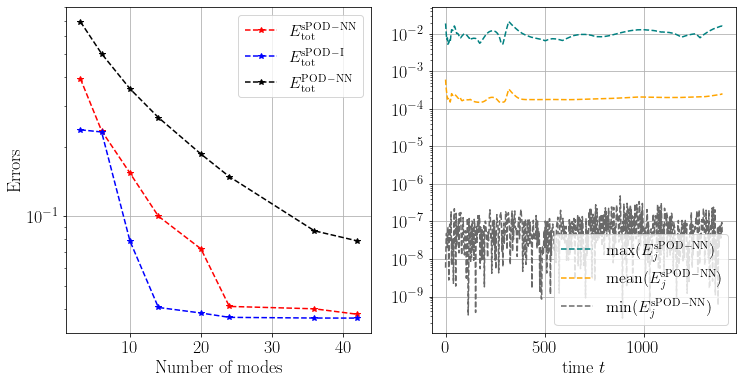

In [25]:
# Error plot for temperature
truncated_modes = np.array([3, 6, 10, 14, 20, 24, 36, 42])
E_sPOD_NN = np.array([0.39350, 0.23411, 0.15384, 0.10032, 0.07252, 0.04094, 0.03998, 0.03789])
E_sPOD_I = np.array([0.23652, 0.23153, 0.07831, 0.04052, 0.03835, 0.03673, 0.03648, 0.03646])
E_POD_NN = np.array([0.69294, 0.50367, 0.35548, 0.26727, 0.18598, 0.14853, 0.08672, 0.07854])

err = errors[0]
err_max = np.amax(err, axis=0)
err_min = np.amin(err, axis=0)
err_mean = np.mean(err, axis=0)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].semilogy(truncated_modes, E_sPOD_NN, color="red", linestyle='--', marker="*", label=r"$E^{\mathrm{sPOD-NN}}_{\mathrm{tot}}$")
axs[0].semilogy(truncated_modes, E_sPOD_I, color="blue", linestyle='--', marker="*", label=r"$E^{\mathrm{sPOD-I}}_{\mathrm{tot}}$")
axs[0].semilogy(truncated_modes, E_POD_NN, color="black", linestyle='--', marker="*", label=r"$E^{\mathrm{POD-NN}}_{\mathrm{tot}}$")
axs[0].set_xlabel('Number of modes')
axs[0].set_ylabel('Errors')
axs[0].grid()
axs[0].legend(loc='upper right')

axs[1].semilogy(df.t, err_max, color="teal", linestyle='--', label=r"max$(E^{\mathrm{sPOD-NN}}_j)$")
axs[1].semilogy(df.t, err_mean, color="orange", linestyle='--', label=r"mean$(E^{\mathrm{sPOD-NN}}_j)$")
axs[1].semilogy(df.t, err_min, color="dimgrey", linestyle='--', label=r"min$(E^{\mathrm{sPOD-NN}}_j)$")
axs[1].set_xlabel(r"time $t$")
axs[1].grid()
axs[1].legend(loc='lower right')


save_fig(filepath=impath + 'Rel_err', figure=fig)
fig.savefig(impath + "Rel_err" + ".eps", format='eps',dpi=600, transparent=True)